In [181]:
import random
import numpy as np
import numpy.typing

import numba 


# TODO min pyver 3.8

import enum
import typing
import abc



class Coordinate(typing.NamedTuple):
    x: int
    y: int

    @classmethod
    def make(cls, x, y):
        return cls(x=int(x), y=int(y))

class Dimension(typing.NamedTuple):
    width: int
    height: int

    @classmethod
    def make(cls, width, height):
        return cls(width=int(width), height=int(height))

class TextSpec(typing.NamedTuple):
    content: str
    size: int
    rotation: float
    position: Coordinate = None




BilevelData = np.typing.NDArray[np.bool_]




# NOTE coord system: origin upper left 
class CanvasBase(abc.ABC):
    class Callbacks(typing.TypedDict):
        f_update: typing.Set[typing.Callable[[BilevelData], typing.Any]]

    def __init__(self):
        self.callbacks = self.Callbacks(
            f_update=set()
        )

    @property
    @abc.abstractmethod
    def dimension(self) -> Dimension:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def data_bilevel(self) -> BilevelData:
        raise NotImplementedError()

    # callbacks: BilevelData: updated region
    def on_update(self, *callbacks: typing.Callable[[BilevelData], typing.Any]):
        self.callbacks['f_update'] |= set(callbacks)
        return self
        
    def off_update(self, *callbacks: typing.Callable[[BilevelData], typing.Any]):
        self.callbacks['f_update'] -= set(callbacks)
        return self

    @abc.abstractmethod
    def text(self, text_spec: TextSpec) -> Dimension:
        raise NotImplementedError()





@numba.jit
def rgba_frac_to_rgba(rgba: np.typing.NDArray):
    return np.multiply(rgba, 255).astype(np.uint8)

@numba.jit
def rgb_apply_a(
    rgb: np.typing.NDArray,
    a: np.typing.NDArray
):
    return (a / 255. * rgb).astype(np.uint8)

class RGBAChannel(enum.IntEnum):
    R = 0
    G = 1
    B = 2
    A = 3


#@numba.jit
def rgba_to_rgb(
    rgba: np.typing.NDArray, 
    rgb_background: np.typing.NDArray
) -> np.typing.NDArray:
    chan = RGBAChannel

    return (
        rgb_apply_a(
            rgb=rgba[..., np.array([chan.R, chan.G, chan.B])], 
            a=rgba[..., np.array([chan.A])]
        ) + rgb_apply_a(
            rgb=rgb_background, 
            a=255 - rgba[..., np.array([chan.A])]
        )             
    )

#@numba.jit
def rgb_to_bilevel(
    rgb: np.typing.NDArray, 
    rgb_background: np.typing.NDArray
) -> np.typing.NDArray:
    rgb = rgb.astype(np.uint8)
    rgb_background = rgb_background.astype(np.uint8)
    
    return (rgb != rgb_background).all(axis=-1)





import matplotlib as mpl
import matplotlib.backends.backend_agg

# TODO rm
import matplotlib.pyplot as plt


import io






# TODO coord needs to be top left!!!!

class Canvas(CanvasBase):
    def __init__(
        self, 
        backend: typing.Type[mpl.figure.FigureCanvasBase]
            =mpl.backends.backend_agg.FigureCanvas,
        figure: mpl.figure.FigureBase=None
    ):
        super().__init__()
        self._base = backend(figure=figure)

    @property
    def _figure(self):
        return self._base.figure

    @property
    def _background_rgb(self) -> np.typing.NDArray:
        r, g, b, _ = rgba_frac_to_rgba(
            np.asarray(self._figure.get_facecolor()), 
        )
        return np.asarray((r, g, b))

    # NOTE dimension follows that in `data_bilevel`
    @property
    def dimension(self) -> Dimension:
        _, _, width, height = self._figure.get_window_extent(
            renderer=self._base.get_renderer()
        ).bounds
        return Dimension.make(width=height, height=width)

    @property
    def data_rgba(self) -> np.typing.NDArray:
        a = np.asarray(
            self._base.copy_from_bbox(self._figure.bbox),
            dtype=np.uint8
        )
        
        # TODO NOTE invert y axis
        #a = a[::-1, :]
        #a = a[:, ::-1]
        return a

    @property
    def data_rgb(self) -> np.typing.NDArray:
        return rgba_to_rgb(
            self.data_rgba, 
            rgb_background=self._background_rgb
        )

    @property
    def data_bilevel(self) -> np.typing.NDArray:
        return rgb_to_bilevel(
            self.data_rgb, 
            rgb_background=self._background_rgb
        )

    # position: coordinate in `data_bilevel`
    # dimension: follows coordinate convention in `data_bilevel`

    # NOTE coordinate convention: xy reversed!
    def text(self, text_spec: TextSpec) -> Dimension:
        def _draw(f: mpl.figure.Figure, render: bool):
            if not render:
                return f.draw_without_rendering()
            return f.draw(renderer=f.canvas.get_renderer())

        def _get_extent(t: mpl.text.Text):
            b = t.get_bbox_patch()
            if b is not None:
                return b.get_window_extent()
            return t.get_window_extent(
                renderer=t.get_figure().canvas.get_renderer()
            )

        # TODO offset
        _, _, width_f, height_f = self._figure.bbox.bounds


        pos = text_spec.position
        t = self._figure.add_artist(
            mpl.text.Text(
                text=text_spec.content,
                size=text_spec.size,
                rotation=text_spec.rotation,
                transform=None  # do not translate xy coords
            )            
        )
        _, _, width, height = _get_extent(t).bounds


        if text_spec.position is not None:
            t.set(
                # TODO NOTE invert y axis!!!!
                x=pos.y, y=height_f - height - pos.x,
                #x=pos.y, y=pos.x
            )
            
            _draw(self._figure, render=True)

            # TODO rm
            print('text', text_spec, _get_extent(t).bounds)   

            for f in self.callbacks['f_update']:
                # TODO
                f(None)
        else:
            # hidden
            t.remove()

        return Dimension.make(width=height, height=width)




# see https://stackoverflow.com/a/27087513/11934495
def _shift(a, offsets, fill_value=np.nan):
    _mom = lambda s: s if s > 0 else 0
    _non = lambda s: s if s < 0 else None

    res = np.full_like(a, fill_value=fill_value)
    res[tuple(np.s_[_mom(o):_non(o)] for o in offsets)] \
        = a[tuple(np.s_[_mom(-o):_non(-o)] for o in offsets)]

    return res




# see https://en.wikipedia.org/wiki/Summed-area_table
class SummedAreaTable:
    @staticmethod
    #@numba.jit
    def _make(a: np.typing.NDArray):
        return np.apply_over_axes(
            np.cumsum, 
            a, 
            axes=np.arange(2)
        )

    def __init__(self, a: np.typing.NDArray):
        self.base = self._make(a)

    @staticmethod
    @numba.jit
    def _area(
        a: np.typing.NDArray, 
        offset: Coordinate, 
        block_size: Dimension
    ):
        x, y = offset
        x_block, y_block = block_size

        return (
            (a[x + x_block, y + y_block] - a[x + x_block, y])
                - (a[x, y + y_block] - a[x, y])
        )

    def area(
        self,
        offset: Coordinate,
        block_size: Dimension
    ):
        return self._area(self.base, offset, block_size)

    def walk(
        self,
        block_size: Dimension
    ):
        x_max, y_max = self.base.shape
        x_block, y_block = block_size

        for x in range(x_max - x_block):
            for y in range(y_max - y_block):
                offset = Coordinate(x, y)
                yield offset, self.area(
                    offset=offset, 
                    block_size=block_size
                )

    @staticmethod
    @numba.jit
    def _area_matrix(
        a: np.typing.NDArray, 
        block_size: Dimension
    ):
        x_block, y_block = block_size
        return (
            (a[x_block:, y_block:] - a[x_block:, :-y_block])
                - (a[:-x_block, y_block:] - a[:-x_block, :-y_block])
        )    

    def area_matrix(
        self,
        block_size: Dimension
    ):
        return self._area_matrix(self.base, block_size)

    # TODO test
    def _rm_area_matrix_comp(self,
        block_size: Dimension):

        x_max, y_max = self.base.shape
        x_block, y_block = block_size

        res = np.full(((x_max - x_block), (y_max - y_block)), fill_value=np.nan)
        for x in range(x_max - x_block):
            for y in range(y_max - y_block):
                offset = Coordinate(x, y)
                res[x, y] = self.area(
                    offset=offset, 
                    block_size=block_size
                )

        return res







class OccupancyMap:
    def __init__(
        self, 
        canvas: CanvasBase, 
        mask: typing.Union[np.typing.ArrayLike, None]=None
    ):
        self._canvas = canvas
        self._mask = mask

        self._data = None
        def _f_update(_):
            d = self._canvas.data_bilevel
            if self._mask is not None:
                d += self._mask
            self._data = SummedAreaTable(d.astype(np.uint))
        _f_update(None)
        self._canvas.on_update(_f_update)

    @property
    def canvas(self) -> CanvasBase:
        return self._canvas

    @property
    def data(self) -> SummedAreaTable:
        return self._data

    def query_position(
        self, 
        block_size: Dimension
    ) -> typing.Iterator[Coordinate]:
        for pos, area in self.data.walk(block_size):
            # unoccupied area
            if not area:
                yield pos
    
    def positions(
        self,
        block_size: Dimension
    ):
        a = self.data.area_matrix(block_size)
        # unoccupied area == 0
        return np.argwhere(a == 0)

    def sample_position(
        self, 
        block_size: Dimension, 
        random_state: random.Random
    ) -> Coordinate:
        r = self.positions(block_size)
        if r.size == 0:
            return None
        return Coordinate(*random_state.choice(r))


class Range(typing.NamedTuple):
    min: typing.Any
    max: typing.Any

    def has(self, n) -> bool:
        return self.min <= n and n <= self.max

    @property
    def set(self): return self._replace





class TextPlacement:
    def __init__(self, 
        canvas: CanvasBase, 
        occupancy: OccupancyMap, 
        random_state: random.Random
    ):
        self.canvas = canvas
        self.occupancy = occupancy
        self.random_state = random_state

    def add(
        self, 
        text: str, 
        size_range: typing.Tuple[float, float], 
        size_step: float, 

        # TODO use range object
        #rotation_range: range
        rotation_range: typing.Tuple[float, float], 
        rotation_step: float, 

        rotation_prob: float,
    ) -> TextSpec:
        random_state = self.random_state
        canvas = self.canvas
        occupancy = self.occupancy
        size_min, size_max = size_range
        rotation_min, rotation_max = rotation_range

        def _impl(size: float, rotation: float):
            if size is None:
                return None

            if not (size_min <= size and size <= size_max):
                return None

            if not (rotation_min <= rotation and rotation <= rotation_max):
                return None
            
            dim = canvas.text(TextSpec(
                content=text, 
                size=size, 
                position=None, 
                rotation=rotation
            ))

            # try to find a position
            pos = occupancy.sample_position(dim, random_state=random_state)
            if pos is not None:
                
                # TODO rm debug
                print('try', canvas.dimension, size, rotation, pos)

                return TextSpec(
                    content=text,
                    size=size, 
                    position=pos, 
                    rotation=rotation
                )

            # if we didn't find a place...
            # first try to rotate!
            res = _impl(
                size=size, 
                rotation=rotation + rotation_step
            )
            if res is not None:
                return res

            # make font smaller
            res = _impl(
                size=size - size_step, 
                rotation=rotation
            )
            if res is not None:
                return res

            return None

        rotation = rotation_min
        if random_state.random() < rotation_prob:
            rotation = random_state.choice(
                range(
                    rotation_min, 
                    rotation_max + rotation_step, 
                    rotation_step
                )
            )
        
        return _impl(size=size_max, rotation=rotation)






import collections.abc

class FrequencyData(typing.NamedTuple):
    word: str
    frequency: float

class DescendingFrequencyTable:
    @staticmethod
    def _sorted(a: collections.abc.Iterable[FrequencyData]):
        return sorted(
            a, 
            key=lambda x: x.frequency, 
            reverse=True
        )

    @classmethod
    def from_iter(cls, a: collections.abc.Iterable):
        return cls(map(lambda x: FrequencyData(**x), a))

    try:
        import pandas
        @classmethod
        def from_dataframe(cls, df: pandas.DataFrame):
            return cls.from_iter(df.to_dict('records'))
    except ModuleNotFoundError:
        pass 

    def __init__(self, a: collections.abc.Iterable[FrequencyData]):
        self.base = self._sorted(a)

    def head(self, n):
        inst = self.__new__(self.__class__)
        inst.base = self.base[:n]
        return inst

    @property
    def items(self):
        return self.base

        




class WordCloud:
    class TextParams(typing.TypedDict):
        size_min: int
        size_max: typing.Union[int, None]
        size_step: int
        size_rescaling: float
        rotation_prob: float

    def __init__(
        self, 
        canvas_backend: typing.Type[CanvasBase],
        random_state: random.Random=random.Random()
    ):
        self.canvas_backend = canvas_backend
        self.random_state = random_state

    # mask: boolean mask
    def _generate_layout(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas: CanvasBase,
        bool_mask: typing.Union[np.typing.ArrayLike, None],
        text_props: TextParams
    ) -> typing.Iterator[TextSpec]:
        random_state = self.random_state

        occupancy = OccupancyMap(canvas, mask=bool_mask)
        text_placement = TextPlacement(
            canvas=canvas, 
            occupancy=occupancy, 
            random_state=random_state
        )

        last_freq = None

        for word, freq in frequency_table.items:
            if freq == 0:
                continue

            # select the text size
            text_size_min, text_size_max = text_props['size_min'], text_props['size_max']
            text_size_scaling = text_props['size_rescaling']
            if last_freq is not None and text_size_scaling != 0:
                text_size_max *= (
                    text_size_scaling * (freq / float(last_freq))
                        + (1 - text_size_scaling)
                )

            text_spec = text_placement.add(
                text=word, 
                size_range=(text_size_min, text_size_max), 
                size_step=text_props['size_step'], 
                # TODO
                #rotation_range = (0, 90),
                rotation_range = (0, 0),
                rotation_step = 90,
                rotation_prob=text_props['rotation_prob']
            )
            # we were unable to draw any more
            if text_spec is None:
                break

            # draw the text
            canvas.text(text_spec)
            yield text_spec

            last_freq = freq

            # TODO rm debug
            #continue
            fig, ax = plt.subplots(2)
            ax[0].imshow(text_placement.occupancy.data.base.astype(np.bool_))
            ax[1].imshow(canvas.data_bilevel)
            plt.suptitle(word)
            plt.show()

    def draw(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas_props=dict(),
        bool_mask=None,
        text_props=dict()
    ) -> CanvasBase:
        text_props = {
            **dict(
                size_min=5., size_max=None,
                size_step=1.,
                size_rescaling=.5,
                rotation_prob=.5
            ),
            **text_props
        }

        def _make_canvas():
            return self.canvas_backend(**canvas_props)

        def _find_text_size_max(n_samples):
            nonlocal self, frequency_table, canvas_props

            canvas = _make_canvas()

            # maximum text size when horizontal
            size_max = canvas.dimension.height

            # we only have one word. We make it big!
            if len(frequency_table.items) == 1:
                return size_max

            sizes = np.fromiter(map(
                lambda x: x.size, 
                self._generate_layout(
                    frequency_table=frequency_table.head(n=n_samples),
                    canvas=canvas,
                    bool_mask=bool_mask,
                    text_props={
                        **text_props,
                        'size_max': size_max
                    }
                )
            ), float)
            
            if len(sizes) < 1:
                raise Exception('canvas out of space')

            if len(sizes) == 1:
                return sizes[0]

            return 2 * np.prod(sizes) / np.sum(sizes)

        if text_props.get('size_max', None) is None:
            text_props['size_max'] = _find_text_size_max(
                n_samples=2
            )

        canvas = _make_canvas()
        layout = list(self._generate_layout(
            frequency_table=frequency_table,
            canvas=canvas,
            bool_mask=bool_mask,
            text_props=text_props
        ))

        # TODO
        return canvas

try Dimension(width=480, height=640) 252.0 0 Coordinate(x=50, y=1)
text TextSpec(content='this', size=252.0, rotation=0, position=Coordinate(x=50, y=1)) (1.0, 18.0, 638.875, 339.0)


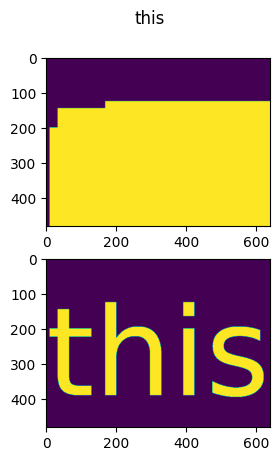

try Dimension(width=480, height=640) 91.0 0 Coordinate(x=0, y=184)
text TextSpec(content='more', size=91.0, rotation=0, position=Coordinate(x=0, y=184)) (184.0, 332.0, 327.375, 122.0)


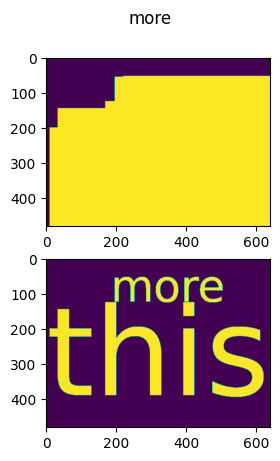

try Dimension(width=480, height=640) 133.71428571428572 0 Coordinate(x=112, y=167)
text TextSpec(content='this', size=133.71428571428572, rotation=0, position=Coordinate(x=112, y=167)) (167.0, 149.0, 339.125, 180.0)


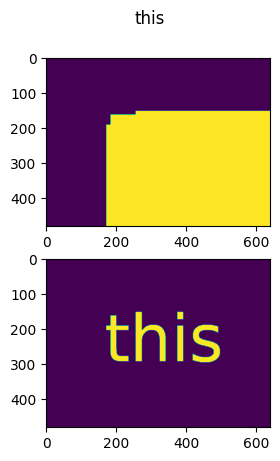

try Dimension(width=480, height=640) 100.28571428571429 0 Coordinate(x=320, y=196)
text TextSpec(content='more', size=100.28571428571429, rotation=0, position=Coordinate(x=320, y=196)) (196.0, -4.0, 360.75, 135.0)


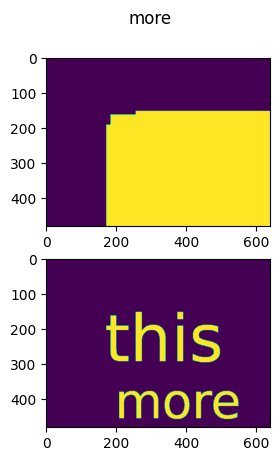

try Dimension(width=480, height=640) 111.71428571428572 0 Coordinate(x=0, y=20)
text TextSpec(content='stuff', size=111.71428571428572, rotation=0, position=Coordinate(x=0, y=20)) (20.0, 298.0, 349.125, 150.0)


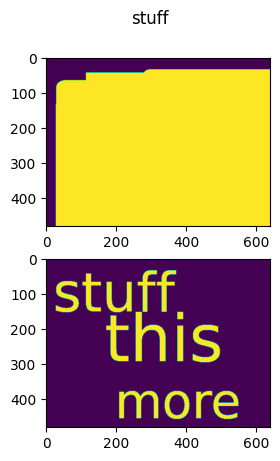

try Dimension(width=480, height=640) 80.22857142857143 0 Coordinate(x=42, y=396)
text TextSpec(content='test', size=80.22857142857143, rotation=0, position=Coordinate(x=42, y=396)) (396.0, 308.0, 213.75, 107.0)


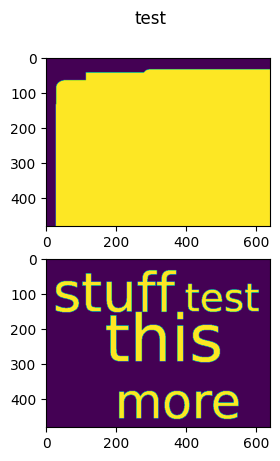

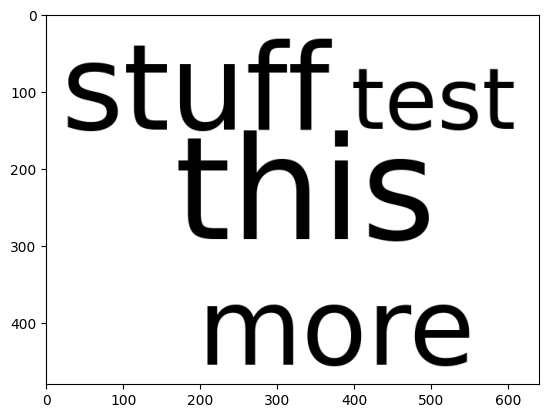

In [182]:
wc = WordCloud(canvas_backend=Canvas)

c = wc.draw(
    frequency_table=DescendingFrequencyTable([
        FrequencyData('test', 1),
        FrequencyData('this', 10),
        FrequencyData('more', 5),
        FrequencyData('stuff', 5),
    ]),
    text_props=dict(
        rotation_prob=0
    )
)
plt.imshow(c.data_rgba)

In [140]:
np.array([1,10,233,23])[np.array([1,2])]

array([ 10, 233])

In [124]:
a = np.empty((480, 640, 1))
rgb = np.empty((480, 640, 3))

rgb * a

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [122]:
np.empty((480, 640, )) * np.empty((480, 640, 3, ))

ValueError: operands could not be broadcast together with shapes (480,640) (480,640,3) 

In [119]:
np.broadcast_to(np.empty((480, 640)), (480, 640, 3))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (480,640)  and requested shape (480,640,3)

In [95]:
rgb_apply_a(
    np.empty((480, 640, 3)),
    np.empty((480, 640))
)

(480, 640, 3) (480, 640)


ValueError: unable to broadcast argument 1 to output array
File "/tmp/ipykernel_14513/1042575346.py", line 1, 

In [92]:
np.empty((4, 5, 7, 6))[..., [RGBAChannel.R, 1]].shape

(4, 5, 7, 2)

In [37]:
np.array([[1],[2],[3]]) * [[3, 2, 1]]

array([[3, 2, 1],
       [6, 4, 2],
       [9, 6, 3]])

In [53]:
np.random.choice([False, True], (6, 4)).astype(np.bool_)

array([[ True,  True, False,  True],
       [ True,  True,  True,  True],
       [ True, False, False,  True],
       [ True,  True,  True,  True],
       [False,  True,  True, False],
       [False,  True,  True, False]])

In [80]:
(6, 4, *(3, ))

(6, 4, 3)

In [79]:
np.broadcast_to(np.random.choice([False, True], (3, )), (6, 4, 3))

array([[[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]]])

In [78]:
np.broadcast_to(np.random.choice([False, True], (3, 2)), (6, 4, 3, 2))

array([[[[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]]],


       [[[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]]],


       [[[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]],

        [[False,  True],
         [ True, False],
         [ True,  True]]],


       [[[False,  True],
         [ True, False],
         [ True,  Tr

In [65]:
np.random.choice([False, True], (6, 4)) * np.random.choice([False, True], (3, 2))

ValueError: operands could not be broadcast together with shapes (6,4) (3,2) 

In [73]:
np.einsum('i...,k...->ik...', np.random.choice([False, True], (6, 4)), np.random.choice([False, True], (3, 2)))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (6,4)->(6,newaxis,4) (3,2)->(3,2) 

In [77]:
np.einsum('ij,k...->ijk...', np.random.choice([False, True], (6, 4)), np.random.choice([False, True], (3, 2))).shape

(6, 4, 3, 2)

In [57]:
np.einsum('ij,k->ijk', np.random.choice([False, True], (6, 4)), (3, 2, 1))

array([[[0, 0, 0],
        [0, 0, 0],
        [3, 2, 1],
        [0, 0, 0]],

       [[3, 2, 1],
        [0, 0, 0],
        [3, 2, 1],
        [0, 0, 0]],

       [[3, 2, 1],
        [3, 2, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[3, 2, 1],
        [3, 2, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[3, 2, 1],
        [0, 0, 0],
        [3, 2, 1],
        [3, 2, 1]],

       [[0, 0, 0],
        [3, 2, 1],
        [0, 0, 0],
        [3, 2, 1]]])

In [44]:
np.empty((6, 4)) * (3, 2, 1)


ValueError: operands could not be broadcast together with shapes (6,4) (3,) 

In [3]:
a = np.random.rand(640, 480)
d = Dimension(10, 5)

v = SummedAreaTable(a).area_matrix(d)
v_compr = SummedAreaTable(a)._rm_area_matrix_comp(d)

assert np.allclose(v, v_compr)

In [15]:
a = np.random.rand(50000, 5000)

In [9]:
%timeit np.argwhere(a == 0)

58.9 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
sa = SummedAreaTable(a)
%timeit _ = sa.area_matrix(d)

2.17 s ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
import numpy as np
x = np.array([[1, 2, 3],[4, 5, 6]])

np.pad(x,((np.nan,0),(1,0)), mode='constant')#[:, :-1]

TypeError: `pad_width` must be of integral type.

In [31]:
import numpy as np

x=np.array([[1,2,3],[4,5,6],[7,8,9]]).view()
print(x)
print(x[::-1,:])

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[7 8 9]
 [4 5 6]
 [1 2 3]]


In [ ]:
fff.transSubfigure

In [3]:
fff.bbox

NameError: name 'fff' is not defined

In [ ]:
fff.get_facecolor()

(1.0, 1.0, 1.0, 1.0)

In [ ]:
mpl.text.Annotation()

matplotlib.text.Annotation

In [17]:
fff = mpl.figure.Figure()
canvas = mpl.backends.backend_agg.FigureCanvas(fff)

In [ ]:
fff.add_artist(mpl.text.Text(10, 300, 'yeehaw', transform=None))

Text(10, 300, 'yeehaw')

In [ ]:
fff.bbox.width

640.0

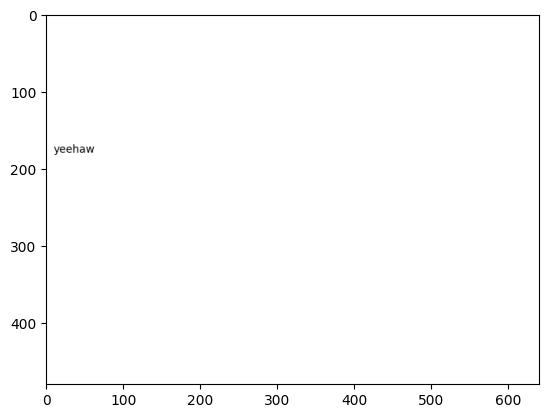

In [ ]:
canvas.draw()

plt.imshow(canvas.buffer_rgba())

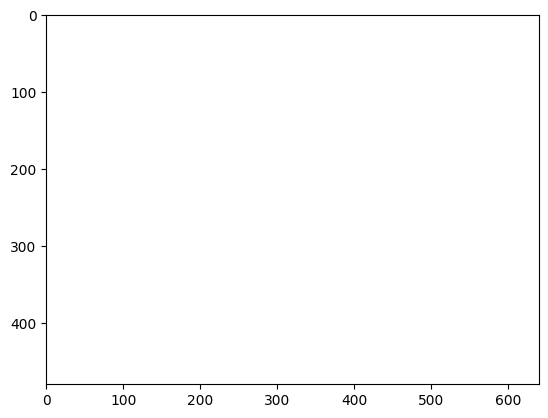

In [ ]:
plt.imshow(canvas.copy_from_bbox(fff.bbox))

In [ ]:
t = fff.text(0, 0, 'test')

In [ ]:
fff.get_tightbbox().y0

-0.03

In [ ]:
t.get_window_extent().y0

-3.0

In [ ]:
canvas.print_png('/tmp/testa.png')

In [ ]:
fff.canvas.tostring_rgb()

AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

In [ ]:
plt.imshow(fff.canvas.buffer_rgba())

AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

In [ ]:
c.fig.text

<bound method FigureBase.text of <Figure size 640x480 with 1 Axes>>

In [ ]:
%%timeit
c.fig.canvas.renderer

61.7 ns ± 1.24 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [15]:
sub.bbox.bounds

(0.0, 240.0, 320.0, 240.0)

In [16]:
fig.bbox.bounds

(0.0, 0.0, 640.0, 480.0)

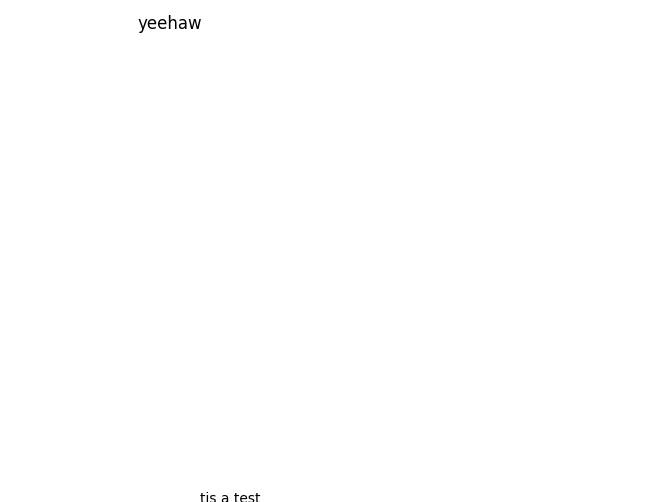

In [24]:
fig = plt.figure()
subfigs = fig.subfigures(2, 2)
sub = subfigs.flatten()[0]

sub.suptitle('yeehaw')

csub = Canvas(figure=sub)
csub.text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))

plt.text(0, 0, '')
plt.show()

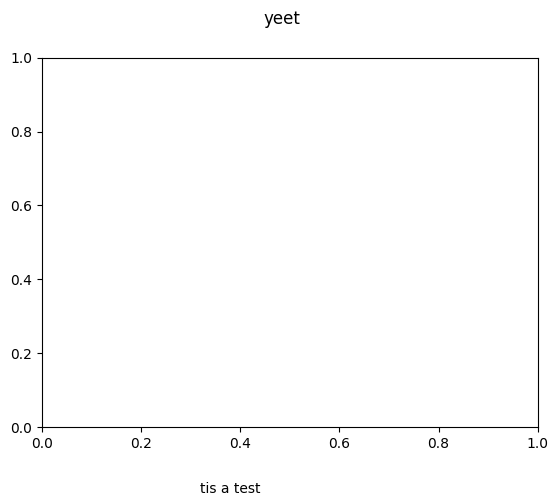

In [28]:
_f = plt.figure()

_f.suptitle('yeet')
Canvas(figure=_f).text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))

plt.text(0, 0, '')
plt.show()

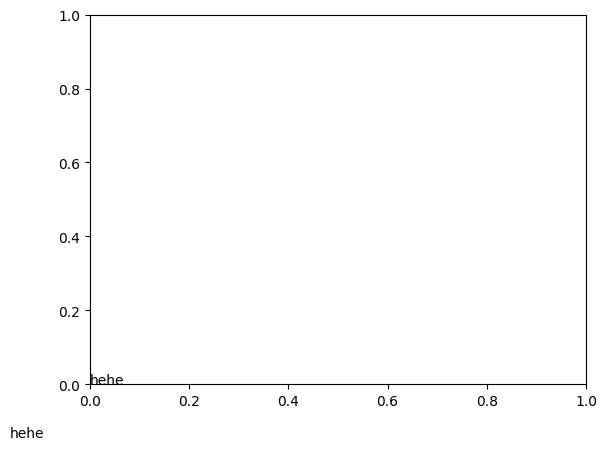

In [10]:

f = plt.figure()
plt.text(0, 0, 'hehe')
f.draw_artist(f.text(0, 0, 'hehe'))
plt.show()


In [5]:
mpl.backends.backend

'module://matplotlib_inline.backend_inline'

In [ ]:
fig.axes

[]

In [ ]:
f.axes

[<AxesSubplot: >]

In [21]:
ffff = mpl.figure.Figure(canvas=mpl.backends.backend_agg.FigureCanvas())


In [ ]:
ffff.dpi_scale_trans.inverted()

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) None
text TextSpec(content='tis a test', size=None, rotation=None, position=Coordinate(x=200, y=0)) (0.0, 277.0, 60.5, 14.0)
(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


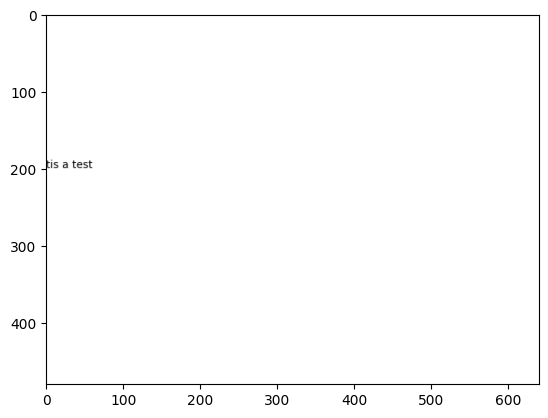

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


In [180]:

c = Canvas(figure=mpl.backends.backend_agg.FigureCanvas(figure=mpl.figure.Figure()).figure)

#c._ax.axis('off')

c_stats = lambda: print(c._base.figure.bbox.bounds, c._base.figure.canvas.figure.bbox.bounds, c._base.figure.canvas._lastKey)


c_stats()
#c.text(TextSpec('tis a test', size=None, position=(0, 0), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(10, 10), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(100, 100), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(640 - 100, 480 - 100), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=480, position=Coordinate(200, 0), rotation=None))
#c_stats()
#plt.imshow(c.data_rgba)
#plt.show()

c.text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))
c_stats()


plt.imshow(c.data_rgba)
plt.show()
c_stats()

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


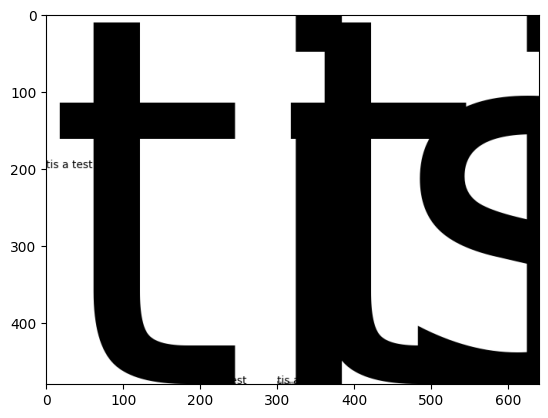

In [ ]:
c.text(TextSpec('tis a test', size=480, position=Coordinate(0, 0), rotation=None))
c_stats()
plt.imshow(c.data_rgba)
plt.show()

In [ ]:
%%timeit
_ = c.data_rgba

33.2 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
_ = c.data_bilevel

3.42 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
c.fig.canvas.buffer_rgba()

292 ns ± 20 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


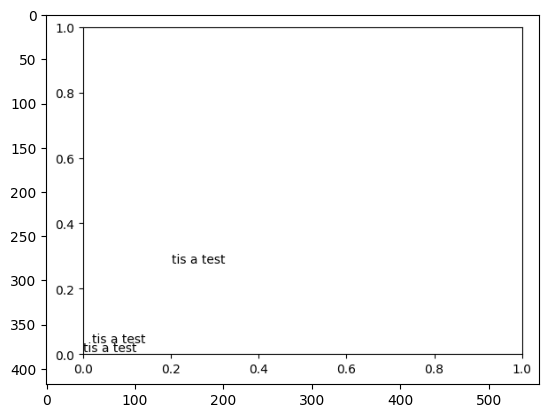

In [ ]:
#%%timeit
plt.imshow(c.fig.canvas.buffer_rgba())

In [ ]:
c.ax.bbox.x0, c.ax.bbox.x1

(80.0, 576.0)

In [ ]:
c.ax.bbox.y0, c.ax.bbox.y1

(52.8, 422.4)

In [ ]:
c.ax.bbox.x0

80.0

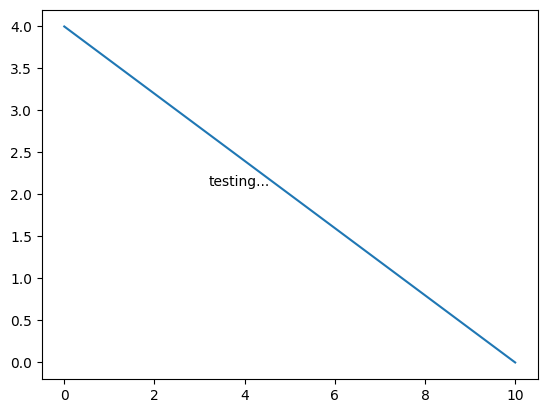

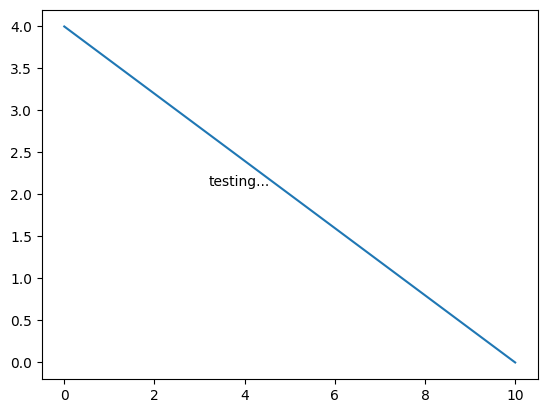

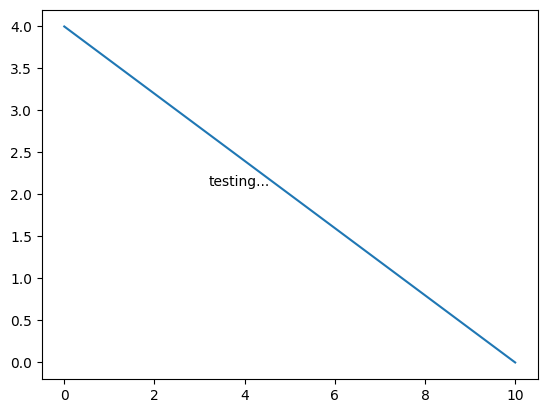

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
ax = f.add_subplot(111)
ax.plot([0,10], [4,0])

t = ax.text(3.2, 2.1, "testing...")
t.set_rotation('horizontal')

import copy

f_ = copy.deepcopy(t.figure)
t.figure

In [ ]:
f_.text(0, 0, 'haha')

Text(0, 0, 'haha')

In [ ]:
_ = f_

In [ ]:
f.bbox.bounds
f.canvas.figure.bbox.bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
c.ax.get_tightbbox()

Bbox([[48.27777777777777, 29.077777777777776], [587.0, 427.9]])

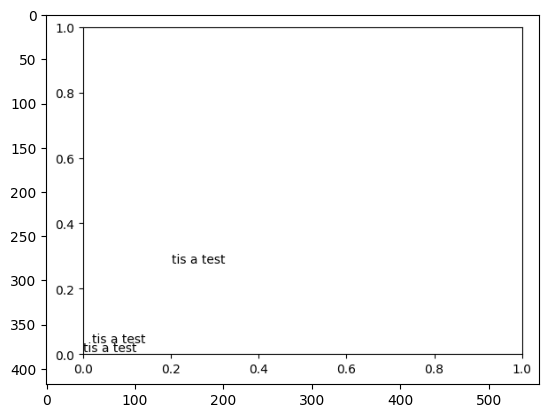

In [ ]:
plt.imshow(c._renderer.buffer_rgba())

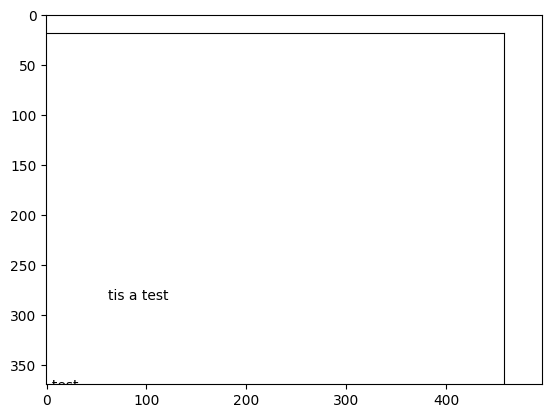

In [ ]:
plt.imshow(c.data_rgba)

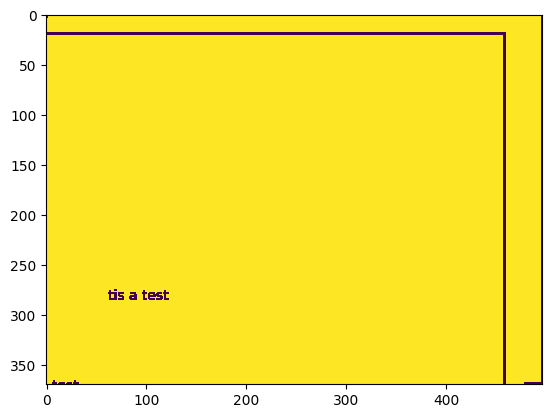

In [ ]:
plt.imshow(c.data_bilevel)

In [ ]:
%%timeit
#plt.imshow
(c.data_rgb)

(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)


In [ ]:
c.fig.canvas.figure.bbox.size

array([640., 480.])

In [ ]:
c.fig.canvas._lastKey

(558.7222222222222, 418.82222222222214, 100.0)

(80.0, 52.8, 496.0, 369.59999999999997)


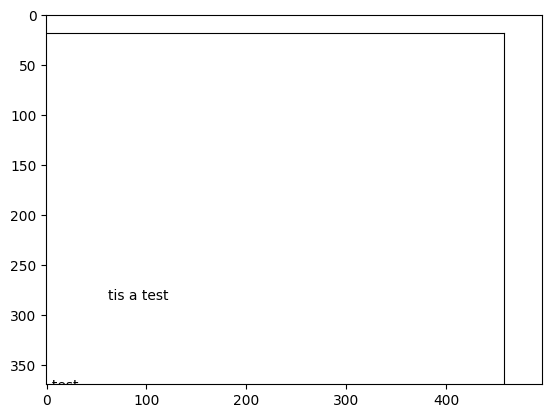

In [ ]:
plt.imshow(c.data_rgba)


(80.0, 52.8, 496.0, 369.59999999999997)


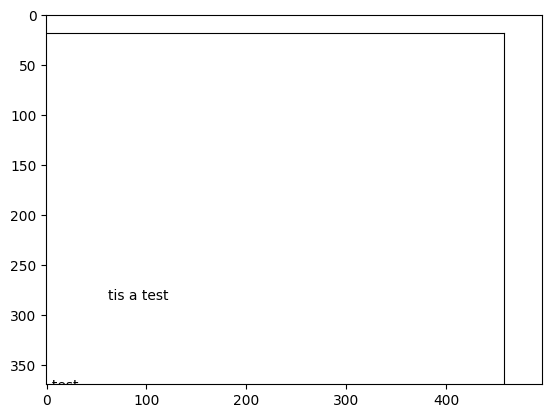

In [ ]:
plt.imshow(c.data_rgb)


20.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


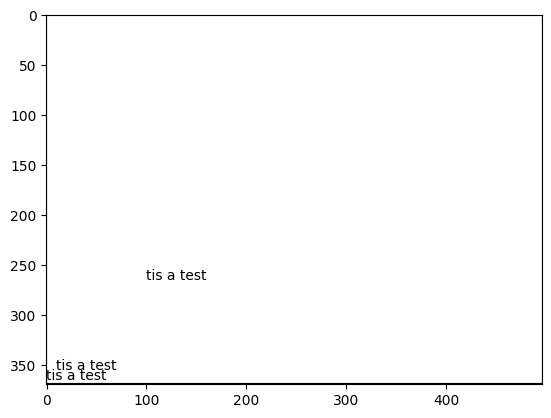

In [ ]:
%%timeit
plt.imshow(c.data_rgb)

In [ ]:
def _rgba_to_rgb(rgba, rgb_background):
    rgba = np.asarray(rgba, dtype=np.uint8)

    r, g, b, a = rgba.T
    r_, g_, b_, a_ = *rgb_background, a / 255.

    rgb = (a_ * (r, g, b) + (1 - a_) * (r, g, b)).T
    return rgb

def _rgb_to_bilevel(rgb, rgb_background):
    rgb, rgb_background = map(
        lambda x: np.asarray(x, dtype=np.uint8), 
        (rgb, rgb_background)
    )

    return (rgb == rgb_background).all(axis=-1)

In [ ]:
_rgba_to_rgb(c.data_rgba,  (255, 255, 255)).shape

(370, 496, 3)

In [ ]:
c.data_rgba[:2, :2]

array([[[255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0]]], dtype=uint8)

In [ ]:
_rgb_to_bilevel(_rgba_to_rgb(c.data_rgba[:2, :2],  (255, 255, 255)), (255, 255, 255)).all(axis=-1)


array([[ True,  True],
       [ True,  True]])

In [ ]:
r, g, b, a = c.data_rgba.T

In [ ]:
r.shape

(496, 370)

In [ ]:
np.asarray(
            c.data_rgba[[0], [0]],
            dtype=[('x', [
                ('r', np.uint8),
                ('g', np.uint8),
                ('b', np.uint8),
                ('a', np.uint8),
            ])
            ]
            #dtype=[
            #    ('x', [
            #        ('r', np.uint8),
            #        ('g', np.uint8),
            #        ('b', np.uint8),
            #        ('a', np.uint8),
            #    ]
            #    ),
            #    ('y', [
            #        ('r', np.uint8),
            #        ('g', np.uint8),
            #        ('b', np.uint8),
            #        ('a', np.uint8),
            #    ]
            #    )
            #]
        )

array([[((255, 255, 255, 255),), ((255, 255, 255, 255),),
        ((255, 255, 255, 255),), ((  0,   0,   0,   0),)]],
      dtype=[('x', [('r', 'u1'), ('g', 'u1'), ('b', 'u1'), ('a', 'u1')])])

In [ ]:
c.data_rgba[[0], [0]]

array([[255, 255, 255,   0]], dtype=uint8)

In [ ]:
c.data_rgba[0].shape

(496, 4)

In [ ]:
c.data_rgba.T.shape

(4, 496, 370)

In [ ]:
np.take(c.data_rgba, [0, 1, 2, 3], axis=2)

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [ ]:
c.data_rgba[0, 0]

array([255, 255, 255,   0], dtype=uint8)

In [ ]:
c.data_rgba

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [ ]:
np.asarray(
    c.data_rgba.T,
dtype=[
    ('r', np.uint8),
    ('g', np.uint8),
    ('b', np.uint8),
    ('a', np.uint8)
]    
)[['r', 'g']].shape


(4, 496, 370)

In [ ]:
c.data_rgba['g']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
c.data_rgba.shape

(370, 496, 4)

In [ ]:
np.squeeze(c.data_rgba.take([0, 1, 2, 3], axis=2)).shape


(370, 496, 4)

In [ ]:
c.ax.get_window_extent(c.fig.canvas.get_renderer()).bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
bb = ax.get_tightbbox()

In [ ]:
ax.bbox

In [ ]:
fig.get_size_inches()

array([6.4, 4.8])

In [ ]:
ax.bbox.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
fig.bbox.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.0, 0.0], [6.4, 4.8]])

In [ ]:
bb.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
ax.get_tightbbox()

Bbox([[80.0, 52.8], [576.0, 422.4]])

In [ ]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

In [ ]:
b = ax.get_window_extent()

In [ ]:
fig.get_window_extent().bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
b.bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
import importlib
importlib.reload(wordcloud)

<module 'wordcloud' from '/home/rexjo/.local/lib/python3.10/site-packages/wordcloud/__init__.py'>

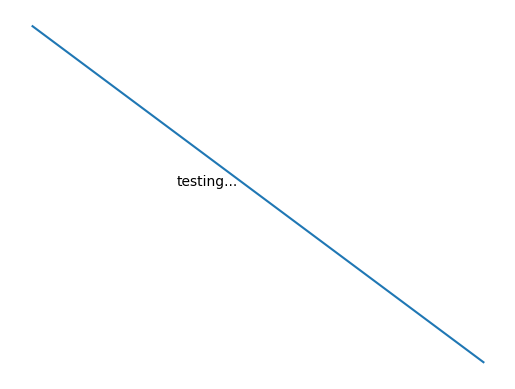

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
ax = f.add_subplot(111)
ax.plot([0,10], [4,0])

ax.axis('off')

t = ax.text(3.2, 2.1, "testing...")
t.set_rotation('horizontal')

# get the inverse of the transformation from data coordinates to pixels
transf = ax.transData.inverted()
bb = t.get_window_extent(f.canvas.get_renderer())
bb_datacoords = bb.transformed(transf)

In [ ]:
canvas = f.canvas

In [ ]:
canvas.renderer.copy_from_bbox

<function RendererAgg.copy_from_bbox>

In [ ]:
canvas.copy_from_bbox

<bound method FigureCanvasAgg.copy_from_bbox of <matplotlib.backends.backend_agg.FigureCanvasAgg object at 0x7f75ada339a0>>

In [ ]:
canvas.copy_from_bbox(ax.bbox)

In [ ]:
aaa = f.canvas.copy_from_bbox(ax.bbox)

In [ ]:
np.array(aaa).shape

(370, 496, 4)

In [ ]:
np.squeeze(np.array(f.canvas.buffer_rgba()))

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [ ]:
f.get_window_extent().bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
aaa.to_string_argb()

In [ ]:
type(aaa)

matplotlib.backends._backend_agg.BufferRegion

In [ ]:
aaa.get_extents()

(80, 58, 576, 428)

In [ ]:
_, _, width, height = aaa.get_extents()

In [ ]:
np.frombuffer(aaa.to_string_argb(), dtype=np.uint8).reshape(width, height, -1)

ValueError: cannot reshape array of size 734080 into shape (576,428,newaxis)

In [ ]:
734080/((576-4)*(428))

2.998496830272531

In [ ]:
734080/((3)*(428))


571.7133956386293

In [ ]:
_, _, width, height = aaa.get_extents()

(80, 58, 576, 428)

In [ ]:
ax.bbox.transformed(
                    f.dpi_scale_trans.inverted()
                )

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
ax.bbox.height

369.59999999999997

In [ ]:
f.bbox.height

480.0

In [ ]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [ ]:
fig2rgb_array(f)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
import copy

In [ ]:
copy.copy(f).show()

AttributeError: Figure.show works only for figures managed by pyplot, normally created by pyplot.figure()

In [ ]:
f.draw(f.canvas.get_renderer())

In [ ]:
ax.get_window_extent().bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
np.isnan(np.frombuffer(f.canvas.tostring_rgb())).all()

False

Bbox([[328.0, 233.59999999999997], [419.125, 251.59999999999997]])

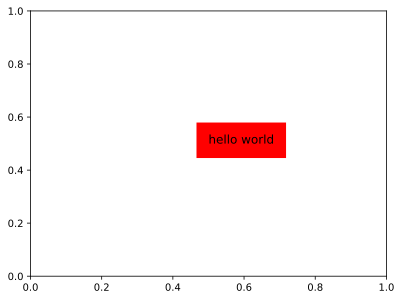

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
a = ax.text(0.5, 0.5, 'hello world', fontsize=12,
            #bbox=None
            #bbox=dict()
            bbox=dict(boxstyle='square,pad=1', fc='red', ec='none', visible=True)
    )
a.get_window_extent()

#plt.close()

In [ ]:
a.get_window_extent()

Bbox([[328.0, 235.10437499999998], [393.85375, 246.71812499999996]])

In [ ]:
a.get_tightbbox().bounds


(328.0, 235.10437499999998, 65.85374999999999, 11.613749999999982)

In [ ]:
a.get_bbox_patch().get_extents() #== a.get_bbox_patch().get_window_extent()

Bbox([[196.663125, 142.4385], [286.516875, 178.05225000000002]])

In [ ]:
a.get_bbox_patch().get_window_extent()

Bbox([[196.663125, 142.4385], [286.516875, 178.05225000000002]])

In [ ]:
a.get_bbox_patch().get_bbox()

Bbox([[0.0, 0.0], [65.85374999999999, 11.61375]])

In [ ]:
t.get_bbox_patch()

In [ ]:
bb

Bbox([[1667.2, 825.9599999999999], [1728.45, 839.9599999999999]])

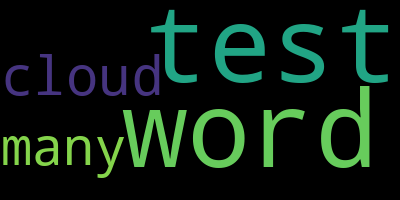

In [ ]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

plt.style.use('default')

import wordcloud

display(wordcloud.WordCloud().generate('this is a test word cloud and many more').to_image())

In [ ]:
dir(wordcloud)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'generate_from_frequencies']

In [ ]:
import wordcloud

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

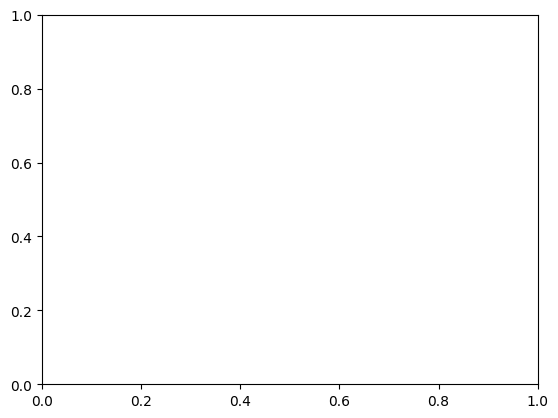

In [ ]:
import matplotlib.pyplot as plt
plt.subplots()

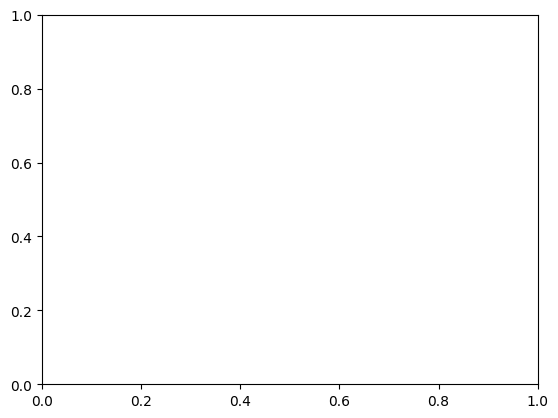

In [ ]:
ax.transData

Text(0.5, 0.5, 'Test 1')

Text(50, 5, 'Test 1')

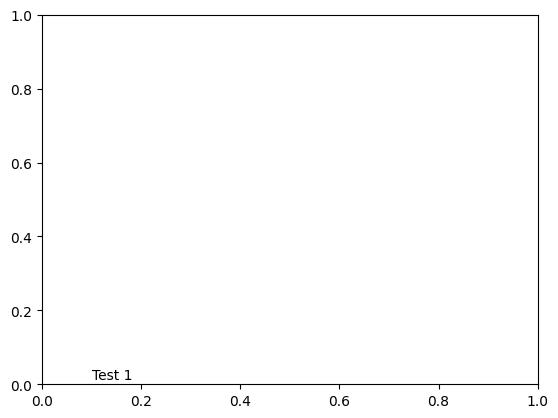

In [ ]:
ax = plt.gca()

#ax.text(5, 5, 'matplotlib')
ax.annotate("Test 1", xy=(50, 5), xycoords='axes pixels')


In [ ]:
ax.transData.transform([0.5, .5])

array([328. , 237.6])

In [ ]:
random.choice((True, False))

True

In [ ]:
random.sample(iter([1, 2, 3]), 6)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
import random

In [ ]:
random.Random()

In [ ]:
import numpy as np


def query_integral_image(
    integral_image, 
    size_x, size_y
):
    x, y = np.shape(integral_image)

    # count how many possible locations
    for i in range(x - size_x):
        for j in range(y - size_y):
            area = integral_image[i, j] + integral_image[i + size_x, j + size_y]
            area -= integral_image[i + size_x, j] + integral_image[i, j + size_y]
            if not area:
                yield i, j